#### Selección del modelo:


Para hacer un mapeo rápido de posibilidades usaremos Pycaret. Pycaret nos permite testear de manera rápida los modelos y poder tener una idea general de qué está funcionando para nuestros datos. En este caso usaremos 90% 10% para train y test. Más allá del Cross Validation que Pycaret ya hace por dentro de por sí. 


In [1]:
#Probando mlflow
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.parse import urlparse

import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    metrics_dict = {'RMSE':rmse, 'MAE': mae, 'R2':r2}
    return metrics_dict

In [2]:
#Load data and set seed
seed = 40

warnings.filterwarnings("ignore")
np.random.seed(seed)
# Read the csv file from the path
csv_path = (
    "../data/train_encoded.csv",
    "../data/test_encoded.csv"
)

try:
    train = pd.read_csv(csv_path[0]).drop(["latitud","longitud"], axis=1)
    test = pd.read_csv(csv_path[1]).drop(["latitud","longitud"], axis=1)
    
except Exception as e:
    logger.exception(
        "Unable to load training & test CSV. Error: %s", e
    )

In [3]:
#train_x = train.select_dtypes(exclude='object').drop(["Precio_m2_total"], axis=1)
#test_x = test.select_dtypes(exclude='object').drop(["Precio_m2_total"], axis=1)
#train_y = train[["Precio_m2_total"]]
#test_y = test[["Precio_m2_total"]]

data = pd.concat([train,test]).reset_index(drop=True)
data_train = data.sample(frac=0.9, random_state=123)
data_test = data.loc[data.index.difference(data_train.index),:]

In [4]:
data_train

,Barrio,Ciudad,Area_total,Area_constr,MONEDA,Area_constr_cat,NroBanios,Dormitorios,Antiguedad,Cocheras,areas_diff,geohash_grado5,geohash_grado6,geohash_grado7,geohash_grado8,geohash_grado9,Precio_m2_total
137,20,2,428.0,428.0,0,14.0,4.0,4.0,21.0,4.0,0.0,6mc73,6mc735,6mc735j,6mc735jk,6mc735jk4,4407.710280
3805,32,2,300.0,300.0,0,9.0,3.0,5.0,22.0,2.0,0.0,6mc74,6mc74p,6mc74p4,6mc74p4h,6mc74p4hd,4050.450000
3417,20,2,330.0,190.0,1,3.0,3.0,4.0,19.0,2.0,140.0,6mc73,6mc732,6mc732w,6mc732w9,6mc732w94,5037.878788
5257,20,2,900.0,480.0,1,16.0,5.0,4.0,22.0,4.0,420.0,6mc73,6mc732,6mc7325,6mc7325j,6mc7325j3,7194.444444
5432,31,2,137.0,209.0,1,4.0,3.0,4.0,45.0,2.0,-72.0,6mc5p,6mc5p5,6mc5p57,6mc5p576,6mc5p576t,14306.569343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5496,52,2,600.0,600.0,0,18.0,4.0,4.0,28.0,4.0,0.0,6mc70,6mc70r,6mc70r4,6mc70r4f,6mc70r4fg,5600.000000
862,31,2,420.0,420.0,0,14.0,3.0,4.0,32.0,3.0,0.0,6mc4z,6mc4zr,6mc4zrd,6mc4zrdg,6mc4zrdge,9245.238095
4940,8,2,180.0,120.0,0,1.0,4.0,6.0,18.0,1.0,60.0,6mchr,6mchrm,6mchrm4,6mchrm4w,6mchrm4w1,1775.000000
3899,20,2,700.0,450.0,1,15.0,4.0,4.0,18.0,4.0,250.0,6mc73,6mc738,6mc738u,6mc738u8,6mc738u8n,6500.000000


In [ ]:
from pycaret.regression import *

exp_101 = setup(data = data_train.select_dtypes(exclude='object'),
               target = "Precio_m2_total", session_id = 104,
               normalize = True, remove_multicollinearity = True, log_experiment = True,
               experiment_name = 'experiment_104(less_without_lat_long)')

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.1
INFO:logs:Initializing setup()
INFO:logs:setup(target=Precio_m2_total, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:25:14
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


INFO:logs:Importing libraries
INFO:logs:Copying data for preprocessing
INFO:logs:Declaring preprocessing parameters
INFO:logs:Creating preprocessing pipeline
INFO:logs:Preprocessing pipeline created successfully
ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
INFO:logs:Creating global containers
INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Barrio,Numeric
Ciudad,Categorical
Area_total,Numeric
Area_constr,Numeric
MONEDA,Categorical
Area_constr_cat,Numeric
NroBanios,Numeric
Dormitorios,Numeric
Antiguedad,Numeric
Cocheras,Numeric


In [6]:
top_3_models = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1553.0155,6532235.0624,2496.5630,0.5059,0.4089,0.4796,0.2120
gbr,Gradient Boosting Regressor,1572.3619,6726605.3327,2533.5914,0.4910,0.4161,0.4984,0.2030
rf,Random Forest Regressor,1597.7353,7283625.2620,2654.5456,0.4362,0.4098,0.4842,0.6500
et,Extra Trees Regressor,1655.0482,8045887.6738,2789.6702,0.3787,0.4291,0.4925,0.4970
knn,K Neighbors Regressor,1807.8889,8280780.9500,2835.7298,0.3581,0.4500,0.5277,0.0260
llar,Lasso Least Angle Regression,2074.6152,10370453.5315,3181.3525,0.1892,0.5333,0.7178,0.0160
br,Bayesian Ridge,2072.7840,10391670.1438,3183.7019,0.1866,0.5321,0.7222,0.0130
lasso,Lasso Regression,2074.5231,10394736.5000,3184.1398,0.1862,0.5328,0.7234,0.0140
ridge,Ridge Regression,2074.7577,10395777.4000,3184.2693,0.1861,0.5330,0.7236,0.0150
lar,Least Angle Regression,2075.0203,10396598.2428,3184.3937,0.1860,0.5332,0.7237,0.0190


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 2
INFO:logs:[LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=104, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_esti

In [7]:
lgbm = create_model('lightgbm', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1654.6426,7040013.0727,2653.3023,0.4110,0.4510,0.5553
1,1455.4698,4565905.8551,2136.7980,0.5845,0.3967,0.4830
2,1555.2924,5303642.6618,2302.9639,0.5392,0.4114,0.3741
3,1576.6409,5690443.2218,2385.4650,0.5239,0.4228,0.7572
4,1610.6609,10413809.6201,3227.0435,0.3968,0.3806,0.3063
Mean,1570.5413,6602762.8863,2541.1145,0.4911,0.4125,0.4952
SD,66.6240,2068047.0027,381.4443,0.0741,0.0239,0.1567


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 3
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=104, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [8]:
tuned_lgbm = tune_model(lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1617.4776,5889445.3439,2426.8179,0.4291,0.4735,0.4758
1,1933.5836,9800841.7256,3130.6296,0.2728,0.5007,0.7605
2,1529.7279,5190877.6161,2278.3498,0.5103,0.5000,0.7114
3,1603.0297,5774267.4661,2402.9706,0.4925,0.3913,0.3455
4,1696.9227,5939790.6518,2437.1686,0.5013,0.4482,0.3976
5,1626.6680,5264464.6698,2294.4421,0.5251,0.4454,0.4354
6,1664.3316,6204272.1797,2490.8376,0.4754,0.4095,0.3634
7,1699.9097,6248029.7974,2499.6059,0.4826,0.5685,1.3353
8,1609.8143,5167681.6827,2273.2535,0.5181,0.4331,0.3607
9,1891.0451,17736348.0778,4211.4544,0.2517,0.4439,0.3809


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 4
INFO:logs:LGBMRegressor(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=2, objective=None,
              random_state=104, reg_alpha=0.7, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


## Interpretación del modelo.

Un proyecto de análisis y modelado de datos es iterativo, es decir, vamos a tener que probar diferentes métodos y evaluar sus respectivos resultados. Si bien podemos hacer un seguimiento de esto con herramientas como mlflow, la principal limitante es solo mantener un registro de las métricas que se generen mas no del proceso analítico. Por eso, en este sección pondremos los primeros modelos con sus respectivas interpretaciones y cambios según un índice alfabético.

**(a) Modelo Base** 
    
    Features: Barrio, Ciudad, Area_total, Area_constr, Area_constr_cat, NroBanios, Dormitorios, Antiguedad, Cocheras, MONEDA.
    nro_features: 10
    train_size = 4980
    test_size = 554
    best_fit = LGBM
    Métricas en train: (MAE,1730) (RMSE, 2730.67) (R2, 0.42) (RMSLE, 0.55) (MAPE, 1.481)
    Conclusión: El modelo subestima el precio de metros cuadrados y la relación con el Area_total es opuesta a la esperada.
    
**(b) Segunda iteración**

    Features: Modelo Base + Diferencias area total - area constr.
    Cambios: Más tratamiendo de outliers
    nro_features: 11
    train_size = 4973
    test_size = 553
    best_fit = LGBM
    687.2510	7321601.9211	2644.5530	0.4459	0.4614	0.5567
    Métricas en train: (MAE,1687) (RMSE, 2644.553) (R2, 0.45) (RMSLE, 0.46) (MAPE, 0.5567)
    Conclusión: Sigue habiendo outliers pero estos afectan algo menos a la inferencia. Mejoran las métricas.
    

In [20]:
test

,Barrio,Ciudad,Area_total,Area_constr,MONEDA,Area_constr_cat,NroBanios,Dormitorios,Antiguedad,Cocheras,areas_diff,geohash_grado5,geohash_grado6,geohash_grado7,geohash_grado8,geohash_grado9,Precio_m2_total
0,43,2,419.0,430.0,1,14.0,4.0,4.0,41.0,3.0,-11.0,6mc5p,6mc5pj,6mc5pjv,6mc5pjvv,6mc5pjvvg,7700.000000
1,52,2,231.0,231.0,0,5.0,3.0,4.0,31.0,2.0,0.0,6mc70,6mc707,6mc707g,6mc707g4,6mc707g45,7606.060606
2,16,2,200.0,200.0,0,4.0,3.0,4.0,28.0,2.0,0.0,6mchn,6mchng,6mchng0,6mchng0r,6mchng0rn,3150.000000
3,44,2,120.0,120.0,0,1.0,3.0,6.0,14.0,1.0,0.0,6mck0,6mck00,6mck00r,6mck00r4,6mck00r48,4566.666667
4,20,2,2535.0,402.0,0,14.0,4.0,4.0,21.0,4.0,2133.0,6mc73,6mc733,6mc733m,6mc733mt,6mc733mth,2506.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,30,1,210.0,298.0,0,8.0,5.0,5.0,12.0,2.0,-88.0,6m5m8,6m5m8j,6m5m8ju,6m5m8jue,6m5m8juex,4900.952381
549,43,2,550.0,304.0,0,9.0,3.0,4.0,34.0,3.0,246.0,6mc5p,6mc5pn,6mc5pn1,6mc5pn1k,6mc5pn1k3,9054.545455
550,31,2,300.0,380.0,0,13.0,3.0,4.0,42.0,2.0,-80.0,6mc5p,6mc5p8,6mc5p8j,6mc5p8j1,6mc5p8j17,8433.333333
551,18,2,480.0,480.0,0,16.0,5.0,10.0,40.0,2.0,0.0,6mc5p,6mc5pc,6mc5pc1,6mc5pc10,6mc5pc10h,1285.000000


##### Gráfico de residuales:

Los residuales son la diferencia entre la muestra observada y predicha. (Y - Ý). En este gráfico podemos ver si el modelo presenta heteroscedasticidad, además de observar qué tanto está subestimando o sobrestimando la variable objetivo.

**(a)** Sí presenta heteroscedasticadad. Un modelo no-lineal es adecuado. El modelo sobrestima los precios de una manera más pronunciada dada una mayor cola en los residuales negativos donde el precio predicho es mayor que el objetivo. Esto no quiere decir que haya más proporción de sobrestimación, sino que las sobrestimaciones son más dispersas. A partir de 8000 soles por m2 (predicho) los errores se vuelven más pronunciados.

**(b)** Se sigue teniendo la presencia de outliers pero estos parecen ser menos a excepción dos.

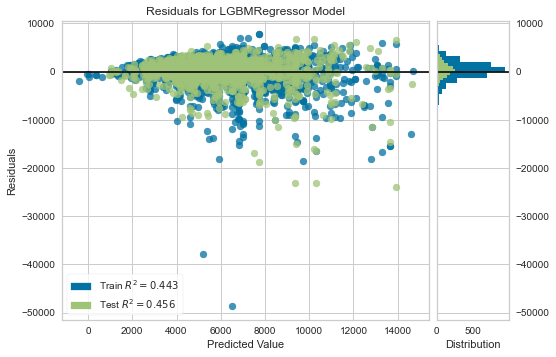

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [10]:
plot_model(tuned_lgbm)

##### Gráfico de tendencia del error. 

Este gráfico muestra la correlación entre los valores predichos y valores reales. Nos va a permitir ver también qué tanta varianza tienen nuestras predicciones, además de ayudarnos a comprar con un fit 'ideal' representado por una línea de 45 grados.

**(a)** Al parecer la varianza es poca y se incrementa cuando el modelo subestima los precios. Dado que la recta está por debajo de los 45 grados, se puede decir que en su mayoría el modelo subestima los precios pero en menor cantidad.

**(b)** El modelo parece haber aumentado su varianza y tiende más a subestimar los precios totales de las casas.

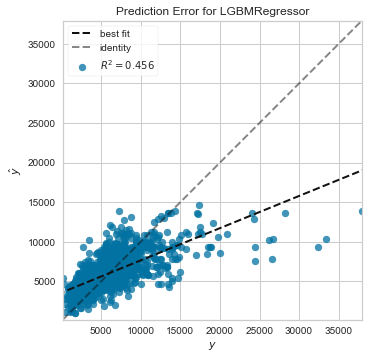

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [11]:
plot_model(tuned_lgbm, plot='error')

##### Distancia de Cooks.

Este gráfico responde a qué tanta influencia tienen los datos cuando se usa una regresión lineal por MCO. Nos sirve para detectar puntos de datos que son altamente influentes en nuestra regresión. 

**(a)** Se confirma que hay outliers que marcan bastante los datos. Cabe resaltar que ya se han removido outliers pero aún queda algunos marcados. El porcentaje de outliers es de 4.10% 

**(b)** El porcentaje de outliers que impactan la tendencia baja a 3.98%. Aún son muy marcados.

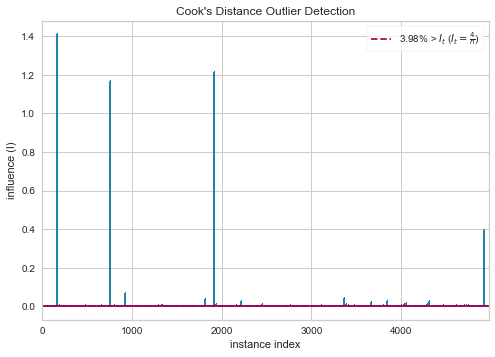

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [12]:
plot_model(tuned_lgbm, plot='cooks')

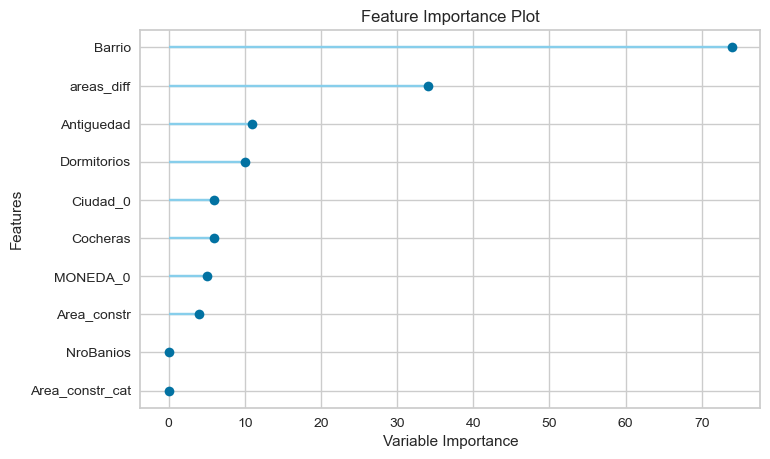

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [13]:
plot_model(tuned_lgbm, plot='feature')

##### SHAP Values. Importancia de variables.

Nos ayuda a explicar de manera agregada modelos complejos. Es importante notar que los valores en la barra (Feature Value) están ordenados por el valor de la variable en sí y las variables en el eje Y aparecen con respecto a qué tanto aportan cambios en esta variable para explicar cambios en el target. 

**(a)** Parece extraño que este gráfico nos dice que mientras que el Area_total sea menor impactara de manera positiva (incrementará) el valor de nuestro target. Al igual que en la antiguedad. Por lo demás genera sentido. Hay que tener también en cuenta que Pycaret genera features por dentro, y que esto puede influir en el modelo.

**(b)** Diferencias negativas en las áreas parecen tener un impacto positivo en el precio. Es decir, mientras el area total sea mucho mayor que el area construida el precio aumenta. También hay que considerar que esto depende del Barrio. Puede ser la presencia de terrenos gigantes en los datos lo que sigue esta tendencia. Además, el valor alto de dormitorios impactando de manera negativa hace algo de ruido.

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=LGBMRegressor(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=2, objective=None,
              random_state=104, reg_alpha=0.7, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), use_train_data=False, X_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


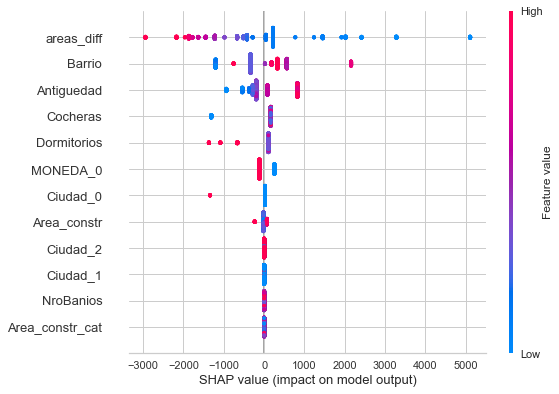

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [21]:
interpret_model(tuned_lgbm)

#### TEST

In [15]:
predictions_df = predict_model(tuned_lgbm, data = data_test.select_dtypes(exclude='object').drop("Precio_m2_total",axis=1))

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMRegressor(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=2, objective=None,
              random_state=104, reg_alpha=0.7, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


In [16]:
eval_metrics(data_test["Precio_m2_total"], predictions_df['Label'])

{'RMSE': 2426.879942140638,
 'MAE': 1658.665528733884,
 'R2': 0.45111185284384636}

In [24]:
tuned_lgbm

LGBMRegressor(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=2, objective=None,
              random_state=104, reg_alpha=0.7, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=104, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### MLFLow:

In [17]:
def _get_params(estimator):
    """
    Obtendremos los parametros del estimador como forma de diccionario para llamar y loggear.
    """
    all_params = estimator.get_params()

    params_to_log = {k:v for k,v in all_params.items() if k in ['alpha','fit_intercept']} #Esto es lo configurable.
    
    return params_to_log
    
def _get_metrics(y_true, y_pred):
    """
    y_pred: predicciones.
    y_true: valores reales del test.
    
    Retornaremos las métricas del estimador como forma de diccionario para llamar y loggear.
    """
    
    metrics_to_log = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE' : mean_absolute_error(y_true, y_pred),
        'R2' : r2_score(y_true, y_pred),
        'MSE' : mean_squared_error(y_true, y_pred)
    }
    
    return metrics_to_log

def log_metrics_params(metrics_to_log, params_to_log):
    for nombre_metrica, valor_metrica in metrics_to_log.items():
        mlflow.log_metric(nombre_metrica, valor_metrica)
    
    for nombre_param, valor_param in params_to_log.items():
        mlflow.log_param(nombre_param, valor_param)

def _my_scorer(estimator, X_test, y_test):
    """
    Esta función va dentro del Loop del GridSearch. Después del fit y antes de la evaluación.
    
    Acá también llamaremos a MlFlow para tener un tracking de los modelos. Así como loggear el mejor modelo luego.
    Podemos aprovechar para loggear entre los batchs.
    
    """
    n = 0
    with mlflow.start_run():
        n+=1
        
        preds = estimator.predict(X_test)
        metricas = _get_metrics(y_test, preds)
        params = _get_params(estimator)
        log_metrics_params(metricas, params)
        est_name = estimator.__class__.__name__
    
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        if tracking_url_type_store != 'file':
            mlflow.sklearn.log_model(estimator, "{}_{}".format(est_name, str(n)),
                                     registered_model_name = "{}_{}".format(est_name, str(n)))
                                                              
        else:
            mlflow.sklearn.log_model(estimator, "{}_{}".format(est_name, str(n)))
        
    return metricas['MSE']

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lasso = Lasso()

parameters = {
    'alpha' : [0.1, 0.5, 2, 4],
    'fit_intercept':[True, False]
}

grid_pipe = GridSearchCV(lasso, parameters, scoring=_my_scorer,cv = 2)

grid_pipe.fit(train_x, train_y)

grid_pipe.best_params_

NameError: name 'train_x' is not defined

In [ ]:
import pycaret

In [ ]:
#Idealmente se crea un sys.argv para poder pasar un argumento desde un .sh 

#alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.5        #<----------------------
#l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.5     #<----------------------

alpha = 0.5
l1_ratio = 0.5

In [ ]:
#Creamos un experimento de MLFlow
experiment_id = mlflow.create_experiment("Linear Models")
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

In [ ]:
LinearRegression().get_params()

In [ ]:
with mlflow.start_run(): ### Qué hace esto..
    
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state = seed)
    lr.fit(train_x, train_y)
    
    predicciones = lr.predict(test_x)
    
    (rmse, mae, r2) = eval_metrics(test_y, predicciones)
    
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    
    #Ahora haremos el log de los parámetros:
    
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme #<-----------------------------
    
    if tracking_url_type_store != "file":
        
        #Existen varias formas de hacer el registro del modelo.
        
        mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticNet_1")
        
    else:
        mlflow.sklearn.log_model(lr,"model")

Fuentes:

https://danielhnyk.cz/adding-callback-to-a-sklearn-gridsearch/

https://stackoverflow.com/questions/61783042/is-there-a-standard-way-to-implement-callbacks-with-gridsearchcv

